<a href="https://colab.research.google.com/github/JoseEliasDuranRoa/Prediction-Models-for-Housing-Prices-in-Chennai/blob/main/ProblemSet1_Dur%C3%A1nRoa_Jos%C3%A9El%C3%ADas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Last Name:** Durán Roa


**First Name:** José Elías



---

# Problem 1: Prediction




## a) Data Cleaning

* Read the data; pay attention to use the right data type for each variable.

In [41]:
#Connect drive
from google.colab import drive
drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
#Import modules
import zipfile, os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
pd.__version__

# Import the data
zip_file_path = '/content/drive/My Drive/chennai.zip'
housing = pd.read_csv(zipfile.ZipFile(zip_file_path).extract('Chennai_housing_sale_2.csv'), index_col = 0)

#Correct data type
housing['DATE_SALE'] = pd.to_datetime(housing['DATE_SALE'], dayfirst=True)
housing['DATE_BUILD'] = pd.to_datetime(housing['DATE_BUILD'], dayfirst=True)
housing['N_BEDROOM'] = housing['N_BEDROOM'].astype('Int64')
housing['N_BATHROOM'] = housing['N_BATHROOM'].astype('Int64')
housing['AGE'] = (housing['DATE_SALE'].dt.year - housing['DATE_BUILD'].dt.year)
housing['AGE'] = housing['AGE'].astype('int64')
housing.drop(columns=['DATE_SALE', 'DATE_BUILD'], inplace=True)

* At this point, we have successfully loaded data related to housing in Chennai, a major city in India, into memory. This data is organized in a DataFrame with 21 distinct variables, which include information about property characteristics, sale prices, construction dates, and various amenities associated with the houses.

* Now, we proceed to identify and correct typos in the categorical columns of the housing dataset. Next, we check for any missing values and print the columns that contain them.



In [43]:
# Identyfing AREA typos
housing.AREA.value_counts()
housing.BUILDTYPE.value_counts()
housing.UTILITY_AVAIL.value_counts()
housing.SALE_COND.value_counts()
housing.PARK_FACIL.value_counts()
housing.STREET.value_counts()

#Fyxing Typos
housing.AREA = housing.AREA.replace(
    {
        'Ana Nagar': 'Anna Nagar',
        'Ann Nagar': 'Anna Nagar',
        'Karapakkam': 'Karapakam',
        'Chrompt': 'Chrompet',
        'Chrmpet': 'Chrompet',
        'Chormpet': 'Chrompet',
        'KKNagar': 'KK Nagar',
        'TNagar': 'T Nagar',
        'Adyr': 'Adyar',
        'Velchery': 'Velachery'
    }
)
housing.BUILDTYPE = housing.BUILDTYPE.replace(
    {'Comercial': 'Commercial', 'Other': 'Others'}
)
housing.UTILITY_AVAIL = housing.UTILITY_AVAIL.replace(
    {'AllPub': 'All Pub', 'NoSewr': 'NoSeWa', 'NoSewr ': 'NoSeWa'}
)
housing.SALE_COND = housing.SALE_COND.replace(
    {'Ab Normal': 'AbNormal', 'PartiaLl': 'Partial', 'Partiall': 'Partial', 'Adj Land': 'AdjLand'}
)
housing.PARK_FACIL = housing.PARK_FACIL.replace('Noo', 'No')
housing.STREET = housing.STREET.replace(
    {'Pavd': 'Paved', 'NoAccess': 'No Access'}
)

#Defining categorical variables
categorical_vars = ['AREA', 'SALE_COND','PARK_FACIL','STREET','MZZONE','UTILITY_AVAIL','BUILDTYPE']
for var in categorical_vars:
   housing[var] = housing[var].astype('category')

#Checking missing values
missing_values = housing.isnull().sum()
print(missing_values[missing_values > 0])

DIST_MAINROAD     8
N_BEDROOM        12
N_BATHROOM        1
QS_OVERALL       46
dtype: int64


To address the issue of missing values, we have two main options: imputation or removing the rows containing missing data. In this case, the only variable with a significant number of missing values is QS_OVERALL. To evaluate whether removing these data points would bias our distribution, we proceed by comparing the distributions of the variable QS_OVERALL between the subset of data that contains missing values and the subset without missing values.


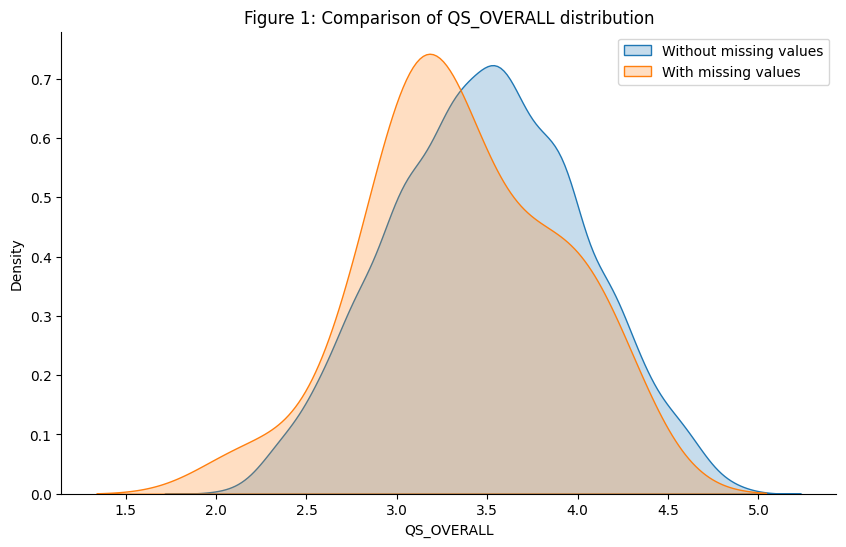

In [44]:
# Subsets of data
missing_subset = housing[housing.isnull().any(axis=1)]
non_missing_subset = housing.dropna()

plt.figure(figsize=(10, 6))
sns.kdeplot(non_missing_subset['QS_OVERALL'], label='Without missing values', fill=True)
sns.kdeplot(missing_subset['QS_OVERALL'].dropna(), label='With missing values', fill=True)
plt.legend()
plt.title('Figure 1: Comparison of QS_OVERALL distribution')
plt.xlabel('QS_OVERALL')
plt.ylabel('Density')
sns.despine()
plt.show()

To confirm the visual analysis, we use the Kolmogorov-Smirnov (KS) test to formally compare the distributions of QS_OVERALL between the two groups, supplementing the visual analysis. A lack of significant difference suggests that removing columns with missing values is unlikely to introduce bias.. Hence we proceed to eliminate missing values.


In [45]:
# Kolmogorov-Smirnov (KS) test
ks_stat, p_value = ks_2samp(non_missing_subset['QS_OVERALL'], missing_subset['QS_OVERALL'].dropna())
print(f'KS Statistic: {ks_stat}, p-value: {p_value}')

KS Statistic: 0.24892350557244175, p-value: 0.12547705802858974


In [46]:
# Delete missing values
housing = housing.dropna()

### a.1) Brief Data Analysis

* The main purpose of this work is to predict housing prices using various predictors related to property characteristics and market conditions. As an initial excercise, we visualize the distribution of the target variable: sale price of the house.

In [47]:
# House prices distribution

fig = px.histogram(
    housing,
    x='SALES_PRICE',
    nbins=100,
    title='<b>Distribution of Housing Prices',
    labels={'SALES_PRICE': 'Housing Price'},
)

fig.update_layout(
    title='<b> Figure 2: House Price Distribution in Chennai',
    xaxis_title='House price (Millions)',
    yaxis_title='Frequency',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black',
    bargap=0.2
)

fig.show()

The histogram depicts the distribution of house prices in Chennai. The distribution is right-skewed, meaning higher prices are less frequent, with a peak around 10 million. An interesting observation is that the market has a clear concentration in mid-range prices, while luxury properties, priced above 20 million, are significantly fewer. This pattern is quite common in real estate markets globally, where most homes fall within the affordable to mid-range bracket, and high-end properties are relatively scarce. However, compared to some cities with broader income disparities, the price range here might suggest a more evenly distributed housing market, at least within this segment.  

* We now proceed to perform a general description of the available potential predictors in the database.


In [48]:
# Generate a label dictionary for posterior data visualization

labels = {
    'PRT_ID': 'House ID',
    'AREA': 'Location',
    'INT_SQFT': 'Area (sqft)',
    'AGE': 'Age of the House',
    'DIST_MAINROAD': 'Distance to Main Road',
    'N_BEDROOM': 'Number of Bedrooms',
    'N_BATHROOM': 'Number of Bathrooms',
    'N_ROOM': 'Total Rooms',
    'SALE_COND': 'Sale Condition',
    'PARK_FACIL': 'Parking Facility',
    'BUILDTYPE': 'Building Type',
    'UTILITY_AVAIL': 'Utility Availability',
    'STREET': 'Street Condition',
    'MZZONE': 'Market Zone',
    'QS_ROOMS': 'Room Quality',
    'QS_BATHROOM': 'Bathroom Quality',
    'QS_BEDROOM': 'Bedroom Quality',
    'QS_OVERALL': 'Overall Quality',
    'REG_FEE': 'Registration Fee',
    'COMMIS': 'Commission Fee',
    'SALES_PRICE': 'Sale Price'
};

In [49]:
# Stastical Description of Data

describe_df = housing.describe()
describe_df.rename(columns=labels, inplace=True)

fig = px.imshow(
    describe_df,
    text_auto=".2f",
    aspect="auto",
    color_continuous_scale='Blues'
)

fig.update_layout(
    title="Table 1: Descriptive Statistics of Housing Data in Chennai",
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(size=12, color='black'),
    title_font=dict(size=16, color='black'),
    width=1000,
    height=400,
    margin=dict(l=10, r=10, t=60, b=10)
)

fig.update_traces(
    hovertemplate='Value: %{z}',
    zmin=describe_df.min().min(),
    zmax=describe_df.max().max()
)

fig.show()

The summary statistics suggest that, in Chennai’s housing market, property prices vary significantly more than size or quality, implying that factors like location or demand are likely driving price disparities. Most homes are close to main roads, highlighting the importance of accessibility in price determination. Interestingly, while house sizes and quality scores are relatively consistent, price variation is substantial, indicating that higher prices don’t necessarily reflect better quality. Transaction costs, such as registration and commission fees, also scale with price, adding a proportional burden to higher-priced homes, which could further widen affordability gaps.




## b) Data Sampling

All categorical variables in our database are nominal, meaning they do not suggest any hierarchy or order. Therefore, we avoid using label encoding (which assigns a number to each category) since it could imply an artificial order. Instead, we apply dummy encoding, which creates a binary variable for each category while omitting one. This approach helps avoid the dummy variable trap and keeps the estimation matrix non-singular and invertible. This encoding will be used in the estimations for parts c and d. For the models in part e, we will use One Hot Encoding (creating one variable for each category without exclusion) to simplify the construction of the regression tree.

In [50]:
#One Hot Encoder (For the regression tree)
cat_cols = ['AREA', 'SALE_COND', 'PARK_FACIL', 'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE']
housing2 = pd.get_dummies(housing, columns=cat_cols)

# Check the original categories of each variable and store them
original_categories = {}
for col in cat_cols:
    original_categories[col] = housing[col].cat.categories.tolist()  # Get categories as a list
    print(f"{col}: {original_categories[col]}");


#Dummy Encoder (for models with linear dependencies)
housing = pd.get_dummies(housing, columns=cat_cols, drop_first=True)

# Identify the omitted categories
print("Omitted categories:")
for col in cat_cols:
    if original_categories[col]:
        omitted_category = original_categories[col][0]  # The first category is omitted
        print(f"{col}: {omitted_category}")


AREA: ['Adyar', 'Anna Nagar', 'Chrompet', 'KK Nagar', 'Karapakam', 'T Nagar', 'Velachery']
SALE_COND: ['AbNormal', 'AdjLand', 'Family', 'Normal Sale', 'Partial']
PARK_FACIL: ['No', 'Yes']
BUILDTYPE: ['Commercial', 'House', 'Others']
UTILITY_AVAIL: ['All Pub', 'ELO', 'NoSeWa']
STREET: ['Gravel', 'No Access', 'Paved']
MZZONE: ['A', 'C', 'I', 'RH', 'RL', 'RM']
Omitted categories:
AREA: Adyar
SALE_COND: AbNormal
PARK_FACIL: No
BUILDTYPE: Commercial
UTILITY_AVAIL: All Pub
STREET: Gravel
MZZONE: A


Para determinar que variables son relevantes a la hora de explicar el precio de la vivienda hacemos un análisis simple de correlación. Nótese que incluir variables irrelevantes no afectaría... pero sí afectaría...

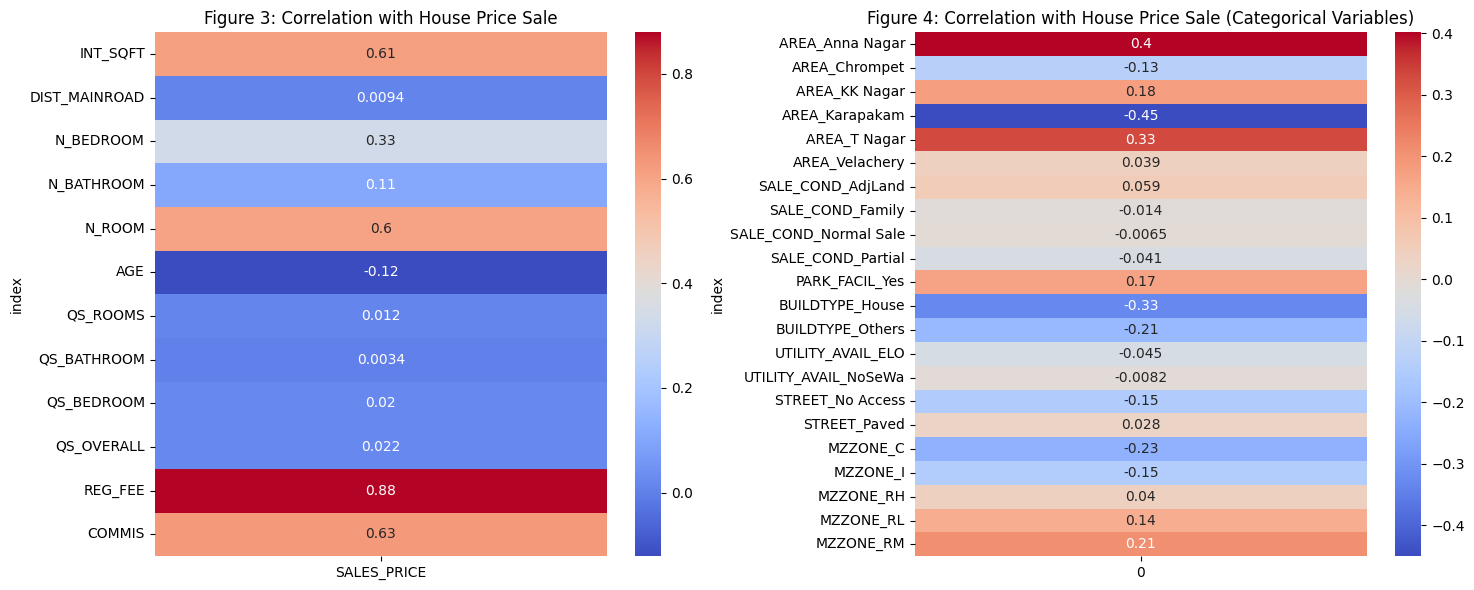

In [51]:
# Calculate and plot correlations with SALES_PRICE

# Non-boolean variables
non_bool_cols = ['INT_SQFT', 'DIST_MAINROAD', 'N_BEDROOM', 'N_BATHROOM', 'N_ROOM',
                 'AGE', 'QS_ROOMS', 'QS_BATHROOM', 'QS_BEDROOM',
                 'QS_OVERALL', 'REG_FEE', 'COMMIS', 'SALES_PRICE']

# Categorical variables
cat_cols = ['AREA_Anna Nagar', 'AREA_Chrompet', 'AREA_KK Nagar', 'AREA_Karapakam',
            'AREA_T Nagar', 'AREA_Velachery', 'SALE_COND_AdjLand', 'SALE_COND_Family',
            'SALE_COND_Normal Sale', 'SALE_COND_Partial', 'PARK_FACIL_Yes',
            'BUILDTYPE_House', 'BUILDTYPE_Others', 'UTILITY_AVAIL_ELO',
            'UTILITY_AVAIL_NoSeWa', 'STREET_No Access', 'STREET_Paved',
            'MZZONE_C', 'MZZONE_I', 'MZZONE_RH', 'MZZONE_RL', 'MZZONE_RM']

# Calculate correlations
non_bool_corr = housing[non_bool_cols].corr()['SALES_PRICE'].drop('SALES_PRICE')
cat_corr = housing[cat_cols].corrwith(housing['SALES_PRICE'])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(non_bool_corr.reset_index().set_index('index'), annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Figure 3: Correlation with House Price Sale')

sns.heatmap(cat_corr.reset_index().set_index('index'), annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Figure 4: Correlation with House Price Sale (Categorical Variables)')

plt.tight_layout()
plt.show()


* In Figure 3, the correlation between the quality of bathrooms, bedrooms, and overall quality is negligible, as expected since these variables are masked data and irrelevant to our analysis. Similarly, the distance to the main road shows no significant correlation. However, the remaining variables demonstrate a substantial relationship with house prices, which we will retain as predictors.

* In Figure 4, neither of the two included categories within the UTILITY_AVAIL variable shows a relevant relationship with house prices, and there is no variability in their correlation with the omitted category. Therefore, we will eliminate the facilities available at the location variable from our analysis.

In [52]:
# Drop irrelevant variables
housing.drop(columns=['QS_ROOMS', 'QS_BATHROOM', 'QS_BEDROOM', 'QS_OVERALL', 'DIST_MAINROAD',
                      'UTILITY_AVAIL_ELO', 'UTILITY_AVAIL_NoSeWa'], inplace=True)

housing2.drop(columns=['QS_ROOMS', 'QS_BATHROOM', 'QS_BEDROOM', 'QS_OVERALL', 'DIST_MAINROAD',
                      'UTILITY_AVAIL_ELO', 'UTILITY_AVAIL_NoSeWa', 'UTILITY_AVAIL_All Pub'], inplace=True)

* Now we proceed to define a Pandas serie with the target variable and a Pandas data frame with the selected relevant predictors. Posteriorly we split our sample into test and training data.

In [53]:
from sklearn.model_selection import train_test_split

y = housing['SALES_PRICE']
X = housing.drop(columns=['SALES_PRICE'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=642815553)

## c) Linear Model Estimation

* Estimate a linear regression model by OLS using your preferred specification or specifications for prediction. You can use pre-processing steps if necessary (for polynomials, interactions, dealing with NAs, etc.). Comment on the results.

* Obtain the RMSE and the MAE as metrics of predictive performance of the model(s).



In [54]:
# First we run a simple OLS without polynomials and interactions
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

lm = LinearRegression()
lm.fit(X_train, y_train)

#coefficients
print(f'Interc. = {lm.intercept_}')
print(f'Coef.   = {lm.coef_}')

# Metrics
y_test_pred = lm.predict(X_test)
print(f'R2= {r2_score(y_test, y_test_pred)}')
print(f'MAE= {mean_absolute_error(y_test, y_test_pred)}')
print(f'RMSE= {mean_squared_error(y_test, y_test_pred, squared = False)}')

Interc. = 5699695.869399842
Coef.   = [ 2.80401486e+03  1.72150640e+05 -3.37905188e+05  2.06530604e+05
  5.78757472e+00  1.87618396e+00 -1.53890531e+04  1.36477895e+06
 -3.80391964e+04 -2.07755048e+06 -2.12132431e+06  1.49294055e+06
 -1.33738649e+06  3.61097453e+05 -3.76977150e+04  3.71575244e+04
 -1.63353781e+05  7.68542148e+05 -3.60799253e+06 -3.06768974e+06
 -8.80459617e+05 -3.66392757e+05  4.04664832e+05  7.95143800e+05
  1.26502856e+06  1.73129221e+06  2.27279236e+06]
R2= 0.9663437474532018
MAE= 515526.57833200414
RMSE= 698913.2965577148


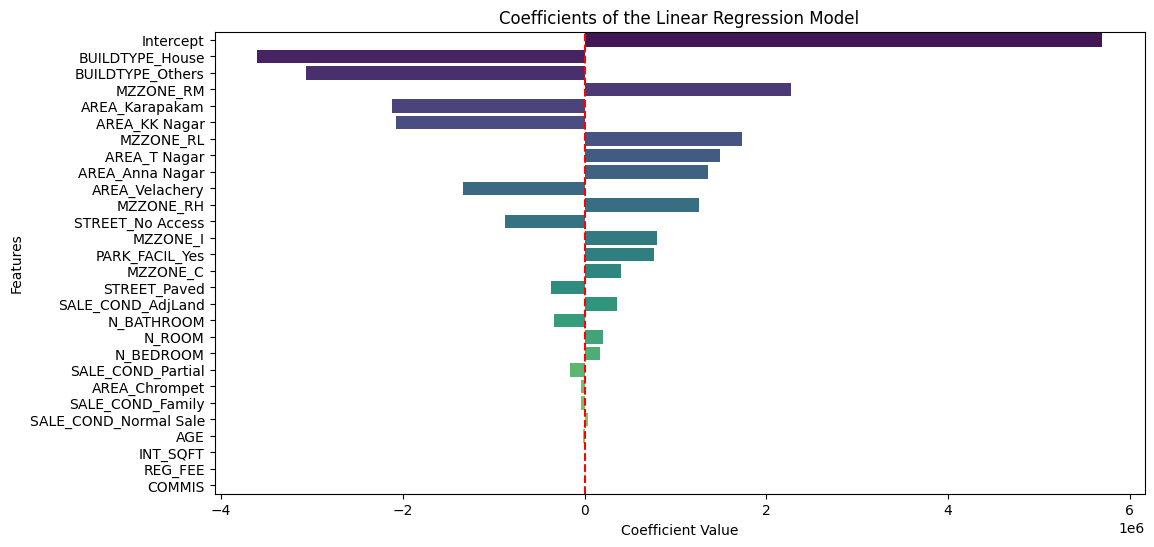

In [55]:
# Create a DataFrame for the coefficients
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(len(lm.coef_))]
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lm.coef_})

# Create a DataFrame for the intercept
intercept_df = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [lm.intercept_]})

# Concatenate the DataFrame with the intercept
coef_df = pd.concat([coef_df, intercept_df], ignore_index=True)

# Sort the DataFrame by the absolute value of coefficients
coef_df['abs_coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

# Plotting the coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
plt.title('Coefficients of the Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.axvline(0, color='red', linestyle='--')  # Add a line at x=0 for reference
plt.show()


> Your comments here


## d) Lasso estimation

* Estimate a LASSO model using the pre-processing steps that you consider necessary. Note that you must choose the optimal value of the penalization hyperparameter by cross-validation before estimating the best LASSO model (which use that value)

* Comment on the results.

* Obtain the RMSE and the MAE as metrics of predictive performance of the model.

In [ ]:
# Lasso estimation


> Your comments here


## e)

* Estimate a regression tree model using the pre-processing steps that you consider necessary. Note that you must choose the optimal value of the hyperparameters by cross-validation before estimating the best tree model. You can focus on tuning the cost-complexity parameter; you can fix the `min_samples_leaf` to a value of your choice (you can try a few of them before choosing one).

* Show a figure with the resulting tree. Comment on the results.

* Show in a table the variable importance according to this model (you can also provide a figure if you want). Comment on the results.

* Obtain the RMSE and the MAE as metrics of predictive performance of the model.

In [ ]:
# Your code here


> Your comments here


## f)

* Estimate a random forest model using the pre-processing steps that you consider necessary. Note that you must choose the optimal value of the hyperparameters by cross-validation before estimating the best model. You can focus on tuning either `min_samples_leaf` or `max_features`, but you should try a few of the other one.

* Show in a table the variable importance according to this model (you can also provide a figure if you want). Comment on the results.

* Obtain the RMSE and the MAE as metrics of predictive performance of the model.

In [ ]:
# Your code here


> Your comments here


## g)

Finally, discuss which prediction model is the best one. Also, briefly comment on any other key insights you can learn from one or more of these models.



> Your comments here


---

# Problem 2: Financial Investment

* This problem is **optional**. Completing it will give you 1 extra point.

* We are interested in estimating the effect of participation in 401(k) pension plans on employees’ net financial assets. The dataset [pension.csv](https://raw.githubusercontent.com/albarran/00datos/refs/heads/main/pension.csv) contains information about net financial assets (*net_tfa*) and participation in a 401(k) plan (*p401*), along with several additional individual characteristics: age, income, education, family size, marital status, having two earners in the household, having a defined benefit (DB) pension (a type of retirement plan where an employer guarantees a specified retirement amount), participation in an IRA (Individual Retirement Account, a type of retirement savings account with tax advantages), and homeownership. You can find more information about the variables [here](https://search.r-project.org/CRAN/refmans/hdm/html/pension.html).

* Since saving preferences (which are unobservable) can directly affect net asset holdings and the decision to participate, and may also be correlated with observable characteristics (e.g., income), participation in 401(k) plans can be endogenous. However, it is possible to exploit randomness (conditional on confounding variables) in eligibility for 401(k) plans (*e401*). An instrumental variable (IV) approach could be used to estimate the causal effect, but in this case, we will focus on estimating the intention-to-treat effect.


* Load the data and check the variables types.

In [ ]:
# Your code here

## a)

* Estimate using OLS a model to examine the effect of 401(k) eligibility on asset holdings, controlling for relevant confounding factors.

* Carefully consider how each variable should enter the model (e.g., whether education should be treated as a continuous or categorical variable). Additionally, consider whether polynomial terms or interaction effects might be useful. There is no universally correct choice, but your decisions should be justified and applied consistently throughout the analysis.

* Show the estimated intention-to-treat effect and its standard error and other relevant information to comment on the evidence on the results.

In [ ]:
# Your code here


> Your comments here


## b)

* Repeat the part a) but estimating now the model using LASSO.

In [ ]:
# Your code here


> Your comments here


## c)

* Repeat the part a) again but using Double-selection LASSO.

* Comment on the differences with the previous results and discuss your overall conclusion about the evidence.

In [ ]:
# Your code here


> Your comments here


## d)

* Finally repeat the estimation of the ITT using Double ML with Random Forest.

* Show the results and discuss

In [ ]:
# Your code here


> Your comments here